In [1]:
library(tidyverse, warn.conflicts = FALSE)
library(lubridate, warn.conflicts = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Predicting Vancouver Bicycle Thefts

STAT 201 Project Group 6

**By:** Benjamin Chang, Dennis Fan, Justin Kung, Selena Shew

## Introduction

The City of Vancouver aims to be on the leading edge of urban sustainability (City of Vancouver, 2020). As part of this strategy, the city encourages individuals to reduce their individual carbon footprints through sustainable commuting (e.g., public transport, biking, and sustainable driving). Of the three sustainable commuting options, biking has the lowest day-to-day carbon footprint. However, Vancouver is ranked as having the highest number of thefts per capita in Canada (Ballard, 2021) and potential cyclists rank fear of bike theft as one of the top deterrents (Agarwal & North, 2012).

Research on bike theft in Canada has already been conducted in Montreal, suggesting bike theft peaks during summer months and that bikes are more frequently stolen during the night (Lierop van et al., 2015). 

Using Crime Data from the Vancouver Police Department (VPD) (https://geodash.vpd.ca/opendata/), we hope to expand on this research but focusing on the city of Vancouver. Our question is "Is there a difference in the mean number of bike thefts between weekdays and weekends, and if there is a difference, is it statistically significant?". We will be calculating a difference in average number of bike thefts *(variable of interest)* between weekdays and weekends *(category)*. Our parameter of interest would be a difference in means (between weekdays and weekends) alongisde a calculation of standard deviation for a better grasp on the variability of the results.

## Preliminary Results

Crime data CSV is read from the web as a tibble.

In [2]:
URL = "http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.csv"
data = read_csv(URL, col_types = cols())
head(data)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


- Filter the crime type to bike thefts
- Create new column called `weekend` with a boolean value indicating weekday/weekend. This is done by manipulating the `YEAR`, `MONTH` and `DAY` columns with some functionality from the `lubridate` library.

In [1]:
bike_crime_data <- data %>%
    filter(TYPE == "Theft of Bicycle") %>%
    mutate(ymdsum = DAY + (MONTH * 100) + (YEAR * 10000)) %>%
    mutate(date = ymd(ymdsum)) %>%
    mutate(day = wday(date)) %>%
    mutate(weekend = (day == 1 | day == 7))

bike_crime_data <- bike_crime_data[-c(11)]
head(bike_crime_data)

ERROR: Error in data %>% filter(TYPE == "Theft of Bicycle") %>% mutate(ymdsum = DAY + : could not find function "%>%"


We can summarize the data below. Points of interest are that there were a total of 33,460 bicycle thefts reported to VPD between 2003-2021 and that 9319 (~28%) occurred on the weekend.

In [17]:
summary(bike_crime_data)

     TYPE                YEAR          MONTH             DAY       
 Length:33460       Min.   :2003   Min.   : 1.000   Min.   : 1.00  
 Class :character   1st Qu.:2009   1st Qu.: 5.000   1st Qu.: 8.00  
 Mode  :character   Median :2014   Median : 7.000   Median :15.00  
                    Mean   :2013   Mean   : 6.904   Mean   :15.22  
                    3rd Qu.:2017   3rd Qu.: 9.000   3rd Qu.:22.00  
                    Max.   :2021   Max.   :12.000   Max.   :31.00  
      HOUR           MINUTE      HUNDRED_BLOCK      NEIGHBOURHOOD     
 Min.   : 0.00   Min.   : 0.00   Length:33460       Length:33460      
 1st Qu.:10.00   1st Qu.: 0.00   Class :character   Class :character  
 Median :15.00   Median : 0.00   Mode  :character   Mode  :character  
 Mean   :13.67   Mean   :13.37                                        
 3rd Qu.:19.00   3rd Qu.:30.00                                        
 Max.   :23.00   Max.   :59.00                                        
       X                Y  

We visualize the data by plotting the total number of bicycle thefts over days of the week (plotted over `day`).

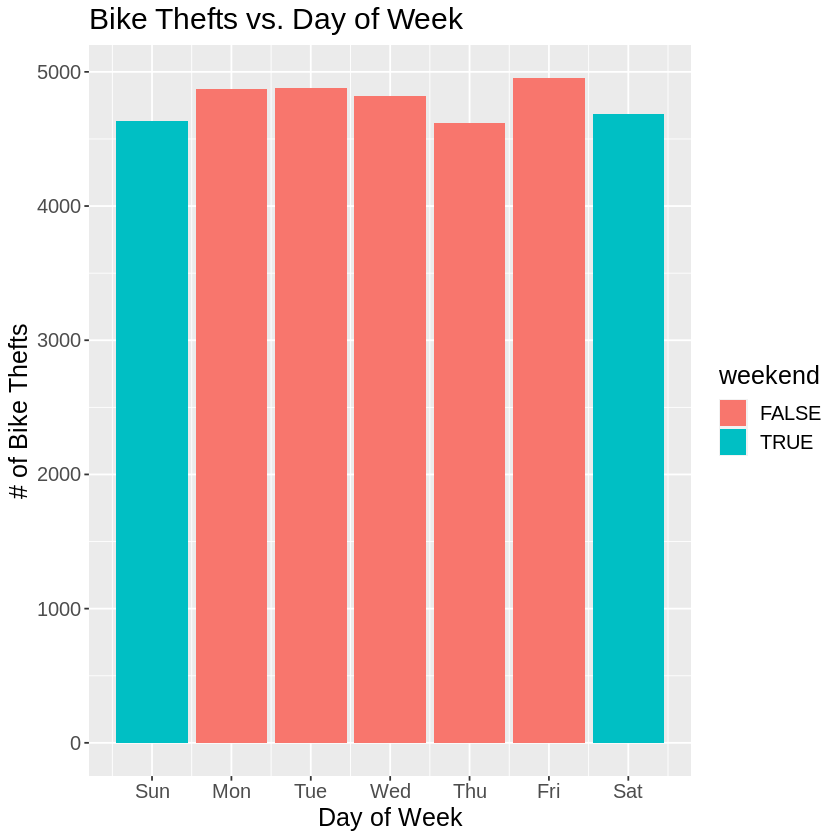

In [26]:
plot_by_day <- bike_crime_data %>%
    ggplot(aes(x = day, fill = weekend)) +
    geom_bar() + 
    scale_x_continuous(breaks=1:7, labels=c("Sun", "Mon","Tue","Wed","Thu","Fri","Sat")) +
    labs(x = "Day of Week", y = "# of Bike Thefts", title = "Bike Thefts vs. Day of Week") +
    theme(text = element_text(size=15))

plot_by_day

We calculate our parameters of interest, the average bike thefts on weekdays and weekends.

In [23]:
grouped_by_weekend <- bike_crime_data %>%
    group_by(weekend) %>%
    summarise(count = n() / length(unique(day))) 

grouped_by_weekend

`summarise()` ungrouping output (override with `.groups` argument)



weekend,count
<lgl>,<dbl>
FALSE,4828.2
TRUE,4659.5


A quick glance suggests a slight increase in bike thefts during weekdays. For better visualization of the data above we plot it below:

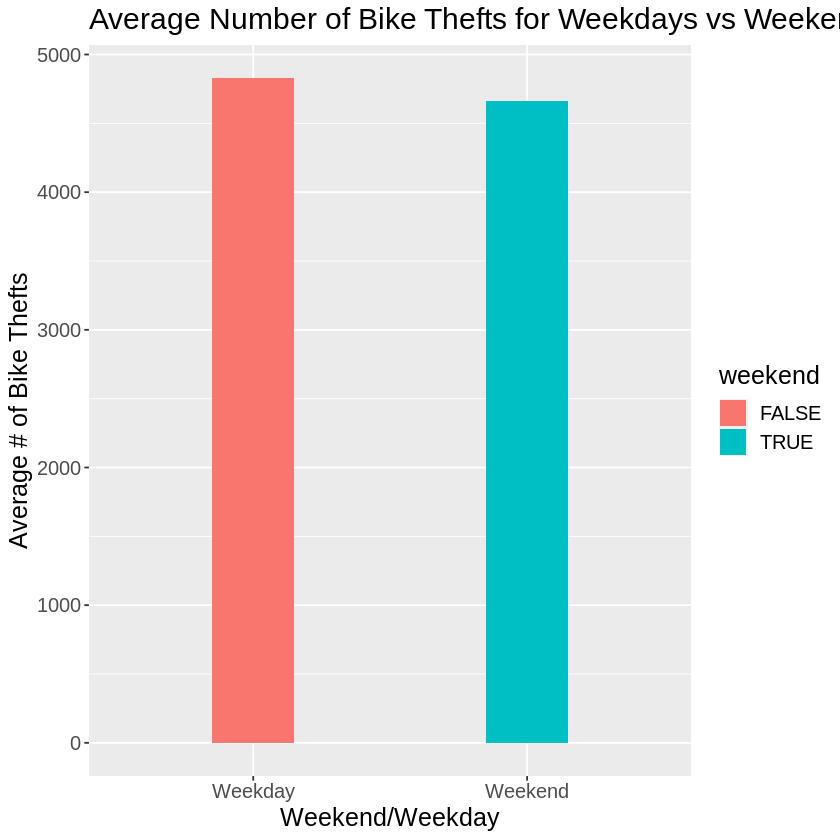

In [28]:
plot_of_means <- grouped_by_weekend %>%
    ggplot(aes(x = weekend, y = count, fill = weekend)) +
    geom_bar(stat = 'identity', width = 0.3) +
    scale_x_discrete(breaks=0:1, labels=c("Weekday", "Weekend")) +
    labs(x = "Weekend/Weekday", y = "Average # of Bike Thefts", title = "Average Number of Bike Thefts for Weekdays vs Weekend") +
    theme(text = element_text(size=15))

plot_of_means

## Methods

The limitations of the above plot is that it cannot be used to make definite generalized statements about Vancouver. For example we cannot say for certain that more bike thefts will always occur on weekdays since we do not have access to data for Vancouver over all years. Therefore a measure of confidence should be provided with our estimates so stakeholders can gain insight into the uncertainty of our calculations. 

Our proposed report will create a reproducible workflow using statistical methods to answer an inferential question. Our data is from a reputable source (VPD) and we use all samples to minimize variance. Through our proposed methodology we also address variation through confidence intervals. 

**Methodology**

Our sample will be the bike theft data of 2019, which we will use to infer about bike theft in Vancouver over the years. Our null hypothesis is that the mean number of bike thefts between weekdays and weekends are the same:

\begin{equation}
H_0: \mu_{Weekday} - \mu_{Weekend} = 0
\end{equation}

 
Our alternate hypothesis is that there is a difference in means:

\begin{equation}
H_A: \mu_{Weekday} - \mu_{Weekend} \neq 0
\end{equation}

 
To obtain our test statistic, we will calculate the difference of average bike thefts on weekdays and weekends. We will then create the null model for our hypothesis test using the infer workflow and permutations of the explanatory variable. Our test statistic will then be plotted on top of the null model, and a p-value will be obtained. In addition, we will calculate a 95% confidence interval for our test statistic.

**Expectations & Significance** 

We expect to find our alternative hypothesis to be true, with there being a difference in the mean number of bike thefts between weekdays and weekends. If the alternate hypothesis is true, we can subsequently investigate whether the mean number of bike thefts is highest during weekdays or weekends, which could be useful for creating future policy plans to dissuade bike thefts (e.g., determine specific days for additional patrolling, or educating public about being more alert). Further questions that can be explored in the future include whether regionality, the time of day between day and night, or whether the COVID-19 pandemic affects the occurrence of bike thefts.

## References

1. Agarwal, A., & North, A. (2012). Encouraging Bicycling among University Students: Lessons from Queen’s University, Kingston, Ontario. Canadian Journal of Urban Research, 21(1), 151–168. http://www.jstor.org/stable/26193886
2. Ballard, J. (2021, February 4). Vancouver still has the most bike thefts per capita among major Canadian cities, despite efforts | CBC News. CBC. https://www.cbc.ca/news/canada/british-columbia/vancouver-still-has-the-most-bike-thefts-per-capita-among-major-canadian-cities-despite-efforts-1.5898575
3. City of Vancouver. (2020). Greenest City Action Plan. https://vancouver.ca/green-vancouver/greenest-city-action-plan.aspx
4. Lierop van, D., Grimsrud, M., & El-Geneidy, A. (2015). Breaking into bicycle theft: Insights from Montreal, Canada. International Journal of Sustainable Transportation.